--------------------------------------------------------------------------------
ASF-DCL: Action State Flow with Dynamics-aware Contrastive Learning
--------------------------------------------------------------------------------
Batch size: 64
Epochs: 50
Learning rate: 0.001

Lambda_dyn: 0.05
Lambda_flow:  0.02
Lambda_proto: 0.05
Lambda_contrast: 0.2

Loading single file: /content/drive/MyDrive/Colab Notebooks/HAR_data/pamap.csv


/tmp/ipython-input-2516933141.py:155: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("subject_id", group_keys=False).apply(_fill_subject_group)


Loaded PAMAP2 Dataset
  X shape : (30353, 128, 36) (N, T, C)
  y shape : (30353,)
  Classes : 12

Total parameters: 101,036

--------------------------------------------------------------------------------
TRAINING
--------------------------------------------------------------------------------
[01/50] Train Loss: 1.420 | F1: 0.6649  |  Test F1: 0.7536 (Best: 0.7536)Saved Best Model
[01/50] Train Loss: 1.420 | F1: 0.6649  |  Test F1: 0.7536 (Best: 0.7536)
[02/50] Train Loss: 0.888 | F1: 0.8553  |  Test F1: 0.8048 (Best: 0.8048)Saved Best Model
[02/50] Train Loss: 0.888 | F1: 0.8553  |  Test F1: 0.8048 (Best: 0.8048)
[03/50] Train Loss: 0.775 | F1: 0.8883  |  Test F1: 0.9034 (Best: 0.9034)Saved Best Model
[03/50] Train Loss: 0.775 | F1: 0.8883  |  Test F1: 0.9034 (Best: 0.9034)
[04/50] Train Loss: 0.712 | F1: 0.9031  |  Test F1: 0.9006 (Best: 0.9034)
[04/50] Train Loss: 0.712 | F1: 0.9031  |  Test F1: 0.9006 (Best: 0.9034)
[05/50] Train Loss: 0.645 | F1: 0.9183  |  Test F1: 0.9168 (Best

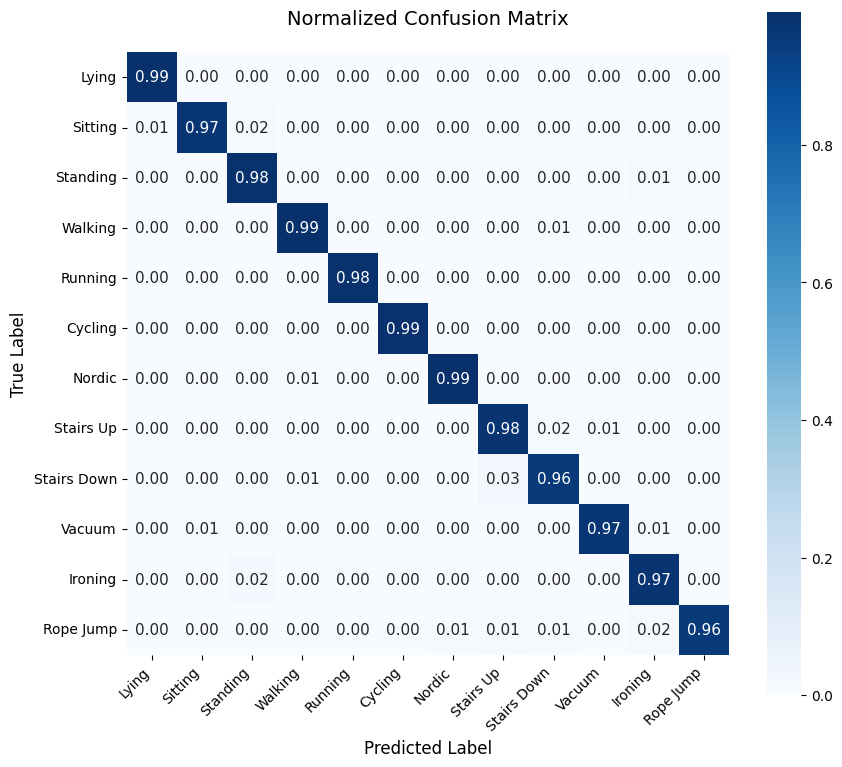

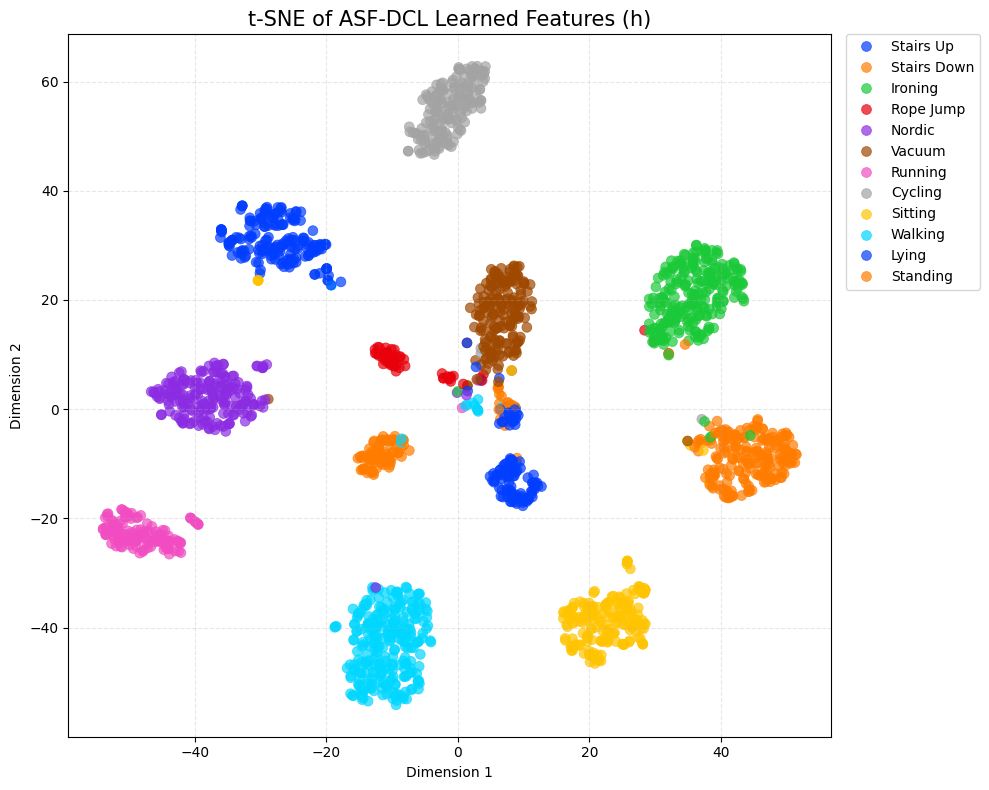

In [1]:
import os
import re
import time
import glob
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# ------------------------------------------------------------------------------
# 1. PAMAP2 Dataset
# ------------------------------------------------------------------------------
def create_pamap2_windows(df: pd.DataFrame, window_size: int, step_size: int):
    feature_cols = [
        # hand
        "handAcc16_1","handAcc16_2","handAcc16_3",
        "handAcc6_1","handAcc6_2","handAcc6_3",
        "handGyro1","handGyro2","handGyro3",
        "handMagne1","handMagne2","handMagne3",
        # chest
        "chestAcc16_1","chestAcc16_2","chestAcc16_3",
        "chestAcc6_1","chestAcc6_2","chestAcc6_3",
        "chestGyro1","chestGyro2","chestGyro3",
        "chestMagne1","chestMagne2","chestMagne3",
        # ankle
        "ankleAcc16_1","ankleAcc16_2","ankleAcc16_3",
        "ankleAcc6_1","ankleAcc6_2","ankleAcc6_3",
        "ankleGyro1","ankleGyro2","ankleGyro3",
        "ankleMagne1","ankleMagne2","ankleMagne3",
    ]

    old2new = {
        1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5,
        7: 6, 12: 7, 13: 8, 16: 9, 17: 10, 24: 11
    }

    label_names = [
        "Lying", "Sitting", "Standing", "Walking", "Running", "Cycling",
        "Nordic walking", "Ascending stairs", "Descending stairs",
        "Vacuum cleaning", "Ironing", "Rope jumping"
    ]

    X_list = []
    y_list = []
    subj_list = []

    for subj_id, g in df.groupby("subject_id"):
        if "timestamp" in g.columns:
            g = g.sort_values("timestamp")
        else:
            g = g.sort_index()

        data_arr  = g[feature_cols].to_numpy(dtype=np.float32)
        label_arr = g["activityID"].to_numpy(dtype=np.int64)
        L = data_arr.shape[0]

        start = 0
        while start + window_size <= L:
            end = start + window_size
            last_label_orig = int(label_arr[end - 1])

            if last_label_orig == 0 or last_label_orig not in old2new:
                start += step_size
                continue

            window_ct = data_arr[start:end].T  # (T, C) -> (C, T)

            X_list.append(window_ct)
            y_list.append(old2new[last_label_orig])
            subj_list.append(int(subj_id))

            start += step_size

    if not X_list:
         print("Warning: No windows created from the provided data.")
         return np.empty((0, len(feature_cols), window_size)), np.empty(0), np.empty(0), label_names

    X = np.stack(X_list, axis=0).astype(np.float32)
    y = np.asarray(y_list, dtype=np.int64)
    subj_ids = np.asarray(subj_list, dtype=np.int64)

    return X, y, subj_ids, label_names

class PAMAP2Dataset(Dataset):
    def __init__(self, data_path, window_size=128, step_size=64):
        super().__init__()

        if os.path.isfile(data_path):
            csv_files = [data_path]
            print(f"Loading single file: {data_path}")
        else:
            csv_files = glob.glob(os.path.join(data_path, "*.csv"))
            print(f"Loading {len(csv_files)} files from directory: {data_path}")

        if len(csv_files) == 0:
            raise RuntimeError(f"No CSV files found in {data_path}")

        dfs = []
        for fpath in sorted(csv_files):
            df_i = pd.read_csv(fpath)

            if "subject_id" not in df_i.columns:
                m = re.findall(r"\d+", os.path.basename(fpath))
                subj_guess = int(m[0]) if len(m) > 0 else 0
                df_i["subject_id"] = subj_guess

            dfs.append(df_i)

        df = pd.concat(dfs, ignore_index=True)
        df = df.dropna(subset=['activityID'])

        df["activityID"] = df["activityID"].astype(np.int64)
        df["subject_id"] = df["subject_id"].astype(np.int64)
        if "timestamp" in df.columns:
            df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce")

        feature_cols = [
            "handAcc16_1","handAcc16_2","handAcc16_3","handAcc6_1","handAcc6_2","handAcc6_3",
            "handGyro1","handGyro2","handGyro3","handMagne1","handMagne2","handMagne3",
            "chestAcc16_1","chestAcc16_2","chestAcc16_3","chestAcc6_1","chestAcc6_2","chestAcc6_3",
            "chestGyro1","chestGyro2","chestGyro3","chestMagne1","chestMagne2","chestMagne3",
            "ankleAcc16_1","ankleAcc16_2","ankleAcc16_3","ankleAcc6_1","ankleAcc6_2","ankleAcc6_3",
            "ankleGyro1","ankleGyro2","ankleGyro3","ankleMagne1","ankleMagne2","ankleMagne3",
        ]

        def _fill_subject_group(g):
            if "timestamp" in g.columns: g = g.sort_values("timestamp")
            else: g = g.sort_index()
            g[feature_cols] = g[feature_cols].interpolate(method="linear", limit_direction="both", axis=0).ffill().bfill()
            return g

        df = df.groupby("subject_id", group_keys=False).apply(_fill_subject_group)
        df[feature_cols] = df[feature_cols].fillna(0.0)

        scaler = StandardScaler()
        df[feature_cols] = scaler.fit_transform(df[feature_cols])

        X, y, subj_ids, label_names = create_pamap2_windows(df, window_size, step_size)

        self.X = np.transpose(X, (0, 2, 1)).astype(np.float32)
        self.y = y
        self.subject_ids = subj_ids
        self.label_names = label_names

        print("=" * 80)
        print("Loaded PAMAP2 Dataset")
        print(f"  X shape : {self.X.shape} (N, T, C)")
        print(f"  y shape : {self.y.shape}")
        print(f"  Classes : {len(self.label_names)}")
        print("=" * 80)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.X[idx]).float(),
            torch.tensor(self.y[idx], dtype=torch.long),
            self.subject_ids[idx]
        )

# ------------------------------------------------------------------------------
# 2. ASF Model Components
# ------------------------------------------------------------------------------

class LatentEncoder(nn.Module):
    def __init__(self, input_channels=9, latent_dim=64):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, latent_dim, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(latent_dim)

    def forward(self, x):
        x = x.transpose(1, 2)
        h = F.relu(self.bn1(self.conv1(x)))
        h = F.relu(self.bn2(self.conv2(h)))
        s = F.relu(self.bn3(self.conv3(h)))
        s = s.transpose(1, 2)
        return s

class FlowComputer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, s):
        B, T, D = s.shape

        flow_raw = s[:, 1:, :] - s[:, :-1, :]
        flow_mag = torch.norm(flow_raw, dim=-1, keepdim=True)
        flow_dir = flow_raw / (flow_mag + 1e-8)

        flow_features = torch.cat(
            [flow_raw, flow_mag.expand(-1, -1, D), flow_dir],
            dim=-1
        )
        return flow_features, flow_raw, flow_mag

class FlowEncoder(nn.Module):
    def __init__(self, flow_dim, hidden_dim=64, num_heads=4):
        super().__init__()
        self.flow_embed = nn.Linear(flow_dim, hidden_dim)
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.flow_conv1 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.flow_conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1, padding=0)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

    def forward(self, flow_features):
        h = self.flow_embed(flow_features)
        h_att, _ = self.attention(h, h, h)

        h_att = h_att.transpose(1, 2)
        h = F.relu(self.bn1(self.flow_conv1(h_att)))
        h = F.relu(self.bn2(self.flow_conv2(h)))

        h_pool = torch.mean(h, dim=-1)
        return h_pool

class StateTransitionPredictor(nn.Module):
    def __init__(self, latent_dim=64, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, s_t):
        B, Tm1, D = s_t.shape
        inp = s_t.reshape(B * Tm1, D)
        out = self.net(inp)
        return out.reshape(B, Tm1, D)

class ASFDCLClassifier(nn.Module):
    def __init__(self,
                 input_channels=9,
                 latent_dim=64,
                 hidden_dim=64,
                 num_classes=6,
                 num_heads=4,
                 projection_dim=128):
        super().__init__()

        self.num_classes = num_classes
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim

        self.latent_encoder = LatentEncoder(input_channels, latent_dim)
        self.flow_computer = FlowComputer()
        self.flow_encoder = FlowEncoder(latent_dim * 3, hidden_dim, num_heads)
        self.state_predictor = StateTransitionPredictor(latent_dim, hidden_dim)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

        self.flow_prototypes = nn.Parameter(
            torch.randn(num_classes, hidden_dim)
        )

        self.projection_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, projection_dim)
        )

    def forward(self, x, return_details=False):
        s = self.latent_encoder(x)

        s_t = s[:, :-1, :]
        s_next = s[:, 1:, :]
        s_pred_next = self.state_predictor(s_t)

        flow_features, flow_raw, flow_mag = self.flow_computer(s)

        h = self.flow_encoder(flow_features)

        z = self.projection_head(h)
        z = F.normalize(z, dim=-1)

        logits = self.classifier(h)

        if not return_details:
            return logits

        details = {
            "s": s,
            "s_t": s_t,
            "s_next": s_next,
            "s_pred_next": s_pred_next,
            "flow_features": flow_features,
            "flow_raw": flow_raw,
            "flow_mag": flow_mag,
            "h": h,
            "z": z,
            "prototypes": self.flow_prototypes
        }
        return logits, details


# ------------------------------------------------------------------------------
# 3. Dynamics-aware Contrastive Loss
# ------------------------------------------------------------------------------
def compute_contrastive_loss(z, labels, temperature=0.07):
    B = z.shape[0]
    device = z.device

    sim_matrix = torch.mm(z, z.t()) / temperature

    labels_expanded = labels.unsqueeze(1)
    positive_mask = (labels_expanded == labels_expanded.t()).float()

    positive_mask = positive_mask - torch.eye(B, device=device)

    mask = torch.eye(B, device=device).bool()
    sim_matrix_masked = sim_matrix.masked_fill(mask, float('-inf'))

    exp_sim = torch.exp(sim_matrix_masked)

    pos_sim = (exp_sim * positive_mask).sum(dim=1)

    all_sim = exp_sim.sum(dim=1)

    has_positive = positive_mask.sum(dim=1) > 0

    if has_positive.sum() == 0:
        return torch.tensor(0.0, device=device)

    loss = -torch.log(pos_sim[has_positive] / (all_sim[has_positive] + 1e-8))

    return loss.mean()


# ------------------------------------------------------------------------------
# 4. ASF-DCL Losses: CE + L_dyn + L_flow_prior + L_proto + L_contrast
# ------------------------------------------------------------------------------
def compute_asf_dcl_losses(logits, details, labels,
                           lambda_dyn=0.1,
                           lambda_flow=0.05,
                           lambda_proto=0.1,
                           lambda_contrast=0.15,
                           dyn_classes=(0, 1, 2),
                           static_classes=(3, 4, 5),
                           dyn_target=0.7,
                           static_target=0.1,
                           proto_tau=0.1,
                           contrast_temp=0.07):
    device = logits.device

    cls_loss = F.cross_entropy(logits, labels, label_smoothing=0.05)

    s_next = details["s_next"]
    s_pred_next = details["s_pred_next"]
    dyn_loss = F.mse_loss(s_pred_next, s_next)

    flow_mag = details["flow_mag"]
    B, Tm1, _ = flow_mag.shape
    flow_mean = flow_mag.mean(dim=1).view(B)

    dyn_mask = torch.zeros_like(flow_mean, dtype=torch.bool)
    static_mask = torch.zeros_like(flow_mean, dtype=torch.bool)
    for c in dyn_classes:
        dyn_mask = dyn_mask | (labels == c)
    for c in static_classes:
        static_mask = static_mask | (labels == c)

    flow_prior_loss = torch.tensor(0.0, device=device)
    if dyn_mask.any():
        dyn_flow = flow_mean[dyn_mask]
        flow_prior_loss = flow_prior_loss + F.mse_loss(
            dyn_flow, torch.full_like(dyn_flow, dyn_target)
        )
    if static_mask.any():
        static_flow = flow_mean[static_mask]
        flow_prior_loss = flow_prior_loss + F.mse_loss(
            static_flow, torch.full_like(static_flow, static_target)
        )

    h = details["h"]
    prototypes = details["prototypes"]

    h_norm = F.normalize(h, dim=-1)
    proto_norm = F.normalize(prototypes, dim=-1)

    sim = h_norm @ proto_norm.t()
    proto_logits = sim / proto_tau
    proto_loss = F.cross_entropy(proto_logits, labels, label_smoothing=0.05)

    z = details["z"]
    contrast_loss = compute_contrastive_loss(z, labels, temperature=contrast_temp)

    total_loss = (
        cls_loss +
        lambda_dyn * dyn_loss +
        lambda_flow * flow_prior_loss +
        lambda_proto * proto_loss +
        lambda_contrast * contrast_loss
    )

    loss_dict = {
        "total": total_loss.item(),
        "cls": cls_loss.item(),
        "dyn": dyn_loss.item(),
        "flow_prior": flow_prior_loss.item(),
        "proto": proto_loss.item(),
        "contrast": contrast_loss.item()
    }
    return total_loss, loss_dict


# ------------------------------------------------------------------------------
# 5. Train / Evaluation
# ------------------------------------------------------------------------------
def train_epoch(model, dataloader, optimizer, device,
                lambda_dyn=0.1, lambda_flow=0.05,
                lambda_proto=0.1, lambda_contrast=0.15, **kwargs):
    model.train()
    total_loss = 0

    all_preds = []
    all_labels = []

    loss_accumulator = {
        "cls": 0.0,
        "dyn": 0.0,
        "flow_prior": 0.0,
        "proto": 0.0,
        "contrast": 0.0
    }

    for batch in dataloader:
        x, y = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()

        logits, details = model(x, return_details=True)
        loss, loss_dict = compute_asf_dcl_losses(
            logits, details, y,
            lambda_dyn=lambda_dyn,
            lambda_flow=lambda_flow,
            lambda_proto=lambda_proto,
            lambda_contrast=lambda_contrast,
            **kwargs
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        for k in loss_accumulator.keys():
            loss_accumulator[k] += loss_dict[k]

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(y.detach().cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    for k in loss_accumulator.keys():
        loss_accumulator[k] /= len(dataloader)

    return avg_loss, acc, f1, loss_accumulator


def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            x, y = batch[0].to(device), batch[1].to(device)

            logits = model(x)
            loss = F.cross_entropy(logits, y)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(y.detach().cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)

    return avg_loss, acc, f1, cm


# ------------------------------------------------------------------------------
# 6. Visulization & Analysis
# ------------------------------------------------------------------------------
PAMAP2_LABELS = [
    "Lying", "Sitting", "Standing",       # Static (0,1,2)
    "Walking", "Running", "Cycling",      # Dynamic
    "Nordic", "Stairs Up", "Stairs Down", # Dynamic
    "Vacuum", "Ironing", "Rope Jump"      # Dynamic
]

def print_header(title):
    print("\n" + "="*80)
    print(f" {title} ")
    print("="*80)

def analyze_flow_statistics_pretty(model, dataloader, device, num_classes=12):
    model.eval()
    flow_stats = {i: [] for i in range(num_classes)}

    with torch.no_grad():
        for batch in dataloader:
            x, y = batch[0].to(device), batch[1].to(device)
            _, details = model(x, return_details=True)
            flow_mag = details["flow_mag"]
            mean_flow_per_sample = flow_mag.mean(dim=1).squeeze(-1).cpu().numpy()

            for i in range(len(y)):
                label = y[i].item()
                flow_stats[label].append(mean_flow_per_sample[i])

    print_header("🌊 FLOW DYNAMICS ANALYSIS")

    print(f"{'ID':<4} {'Activity Name':<18} {'Icon':<6} {'Mean Flow':>12} {'Std Flow':>12}   {'State Type'}")
    print("-" * 80)

    for i in range(num_classes):
        if not flow_stats[i]: continue

        mags = np.array(flow_stats[i])
        mean_val = np.mean(mags)
        std_val = np.std(mags)

        if i < 3: # 0,1,2 (Lying, Sitting, Standing)
            state_type = "Static"
            icon = "🪑"
        elif i in [4, 11]: # Running, Rope Jump
            state_type = "High Dynamic"
            icon = "🏃"
        else:
            state_type = "Dynamic"
            icon = "🚶"

        print(f"{i:<4} {PAMAP2_LABELS[i]:<18} {icon:<6} {mean_val:>12.4f} {std_val:>12.4f}   {state_type}")
    print("-" * 80)


def analyze_contrastive_embeddings_pretty(model, dataloader, device, num_classes=12):
    model.eval()
    all_z = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            x, y = batch[0].to(device), batch[1].to(device)
            _, details = model(x, return_details=True)
            all_z.append(details["z"].cpu())
            all_labels.append(y.cpu())

    all_z = torch.cat(all_z, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    centroids = []
    for i in range(num_classes):
        mask = (all_labels == i)
        if mask.sum() > 0:
            centroids.append(all_z[mask].mean(dim=0))
        else:
            centroids.append(torch.zeros(all_z.shape[1]))
    centroids = torch.stack(centroids)

    print_header("🌌 CONTRASTIVE EMBEDDING SPACE ANALYSIS")

    print("\n[1] Intra-class Cohesion (Lower is better)")
    print(f"{'Activity Name':<20} {'Intra-Dist(Mean)':>20} {'Intra-Dist(Std)':>20}")
    print("-" * 65)

    for i in range(num_classes):
        mask = (all_labels == i)
        if mask.sum() <= 1: continue

        class_z = all_z[mask]
        centroid = centroids[i:i+1]
        dists = torch.norm(class_z - centroid, dim=1)

        print(f"{PAMAP2_LABELS[i]:<20} {dists.mean().item():>20.4f} {dists.std().item():>20.4f}")

    print("\n\n[2] Inter-class Distance Matrix (Centroid to Centroid)")
    print(" " * 14, end="")
    for name in PAMAP2_LABELS:
        print(f"{name[:8]:>9}", end="")
    print("\n" + "-" * 75)

    for i in range(num_classes):
        print(f"{PAMAP2_LABELS[i]:<14}", end="")
        for j in range(num_classes):
            dist = torch.norm(centroids[i] - centroids[j]).item()
            print(f"{dist:>9.3f}", end="")
        print()
    print("-" * 75)


def plot_confusion_matrix_sns(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            x, y = batch[0].to(device), batch[1].to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=PAMAP2_LABELS, digits=4))

    cm = confusion_matrix(all_labels, all_preds, normalize='true')

    plt.figure(figsize=(9, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', square=True,
                xticklabels=PAMAP2_LABELS, yticklabels=PAMAP2_LABELS,
                annot_kws={"size": 11})

    plt.title('Normalized Confusion Matrix', pad=20, fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


def visualize_tsne_features(model, dataloader, device, max_points=2000):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            x, y = batch[0].to(device), batch[1].to(device)
            _, details = model(x, return_details=True)
            h = details["h"]
            features.append(h.cpu())
            labels.append(y.cpu())

    features = torch.cat(features, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    if len(features) > max_points:
        idx = np.random.choice(len(features), max_points, replace=False)
        features = features[idx]
        labels = labels[idx]

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        max_iter=1000,
        random_state=42,
        learning_rate='auto',
        init='pca'
    )
    embedded = tsne.fit_transform(features)

    df_tsne = pd.DataFrame(embedded, columns=['Dim1', 'Dim2'])
    df_tsne['Activity'] = [PAMAP2_LABELS[i] for i in labels]

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=df_tsne,
        x='Dim1',
        y='Dim2',
        hue='Activity',
        palette='bright',
        s=50,
        alpha=0.7,
        edgecolor=None
    )

    plt.title("t-SNE of ASF-DCL Learned Features (h)", fontsize=15)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------
# 7. Main Training Loop
# ------------------------------------------------------------------------------
def main():
    SEED = 42
    set_seed(SEED)

    DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/HAR_data/pamap.csv'
    BATCH_SIZE = 64
    NUM_EPOCHS = 50
    LEARNING_RATE = 0.001
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    INPUT_CHANNELS = 36
    NUM_CLASSES = 12
    STATIC_CLS = (0, 1, 2)
    DYN_CLS = (3, 4, 5, 6, 7, 8, 9, 10, 11)

    LAMBDA_DYN = 0.05
    LAMBDA_FLOW = 0.02
    LAMBDA_PROTO = 0.05
    LAMBDA_CONTRAST = 0.2

    print("-"*80)
    print("ASF-DCL: Action State Flow with Dynamics-aware Contrastive Learning")
    print("-"*80)
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Epochs: {NUM_EPOCHS}")
    print(f"Learning rate: {LEARNING_RATE}")
    print()
    print(f"Lambda_dyn: {LAMBDA_DYN}")
    print(f"Lambda_flow:  {LAMBDA_FLOW}")
    print(f"Lambda_proto: {LAMBDA_PROTO}")
    print(f"Lambda_contrast: {LAMBDA_CONTRAST}")
    print()

    try:
        full_dataset = PAMAP2Dataset(DATA_PATH, window_size=128, step_size=64)
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return

    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(
        full_dataset, [train_size, test_size],
        generator=torch.Generator().manual_seed(SEED)
    )

    g = torch.Generator()
    g.manual_seed(SEED)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=2,
                              worker_init_fn=seed_worker,
                              generator=g)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, num_workers=2,
                             worker_init_fn=seed_worker,
                             generator=g)

    model = ASFDCLClassifier(
        input_channels=INPUT_CHANNELS,
        latent_dim=64,
        hidden_dim=64,
        num_classes=NUM_CLASSES,
        num_heads=4,
        projection_dim=128
    ).to(DEVICE)

    total_params = sum(p.numel() for p in model.parameters())
    print()
    print(f"Total parameters: {total_params:,}")

    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=LEARNING_RATE,
                                 weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=NUM_EPOCHS
    )

    best_acc = 0.0
    best_f1 = 0.0
    best_model_path = 'best_asf_dcl_model.pth'

    print("\n" + "-"*80)
    print("TRAINING")
    print("-"*80)

    for epoch in range(NUM_EPOCHS):
        start_time = time.time()

        train_loss, train_acc, train_f1, loss_dict = train_epoch(
            model, train_loader, optimizer, DEVICE,
            lambda_dyn=LAMBDA_DYN,
            lambda_flow=LAMBDA_FLOW,
            lambda_proto=LAMBDA_PROTO,
            lambda_contrast=LAMBDA_CONTRAST,
            dyn_classes=DYN_CLS,
            static_classes=STATIC_CLS
        )

        test_loss, test_acc, test_f1, test_cm = evaluate(
            model, test_loader, DEVICE
        )

        scheduler.step()

        if test_f1 > best_f1:
            best_f1 = test_f1
            best_acc = test_acc
            torch.save(model.state_dict(), best_model_path)
            save_msg = "Saved Best Model"
        else:
            save_msg = ""

        log_msg = (f"[{epoch+1:02d}/{NUM_EPOCHS}] "
                   f"Train Loss: {train_loss:.3f} | F1: {train_f1:.4f}  |  "
                   f"Test F1: {test_f1:.4f} (Best: {best_f1:.4f}){save_msg}")
        print(log_msg)

        epoch_time = time.time() - start_time
        best_acc = max(best_acc, test_acc)
        best_f1 = max(best_f1, test_f1)

        log_msg = (f"[{epoch+1:02d}/{NUM_EPOCHS}] "
                   f"Train Loss: {train_loss:.3f} | F1: {train_f1:.4f}  |  "
                   f"Test F1: {test_f1:.4f} (Best: {best_f1:.4f})")
        print(log_msg)

    print("\n" + "-"*80)
    print("FINAL EVALUATION & EVALUATION...")
    print("-"*80)

    model.load_state_dict(torch.load(best_model_path))

    test_loss, test_acc, test_f1, test_cm = evaluate(
        model, test_loader, DEVICE
    )
    print(f"Final Result → Best Test F1: {best_f1:.4f} (Acc: {best_acc:.4f})")
    analyze_flow_statistics_pretty(model, test_loader, DEVICE, num_classes=NUM_CLASSES)
    analyze_contrastive_embeddings_pretty(model, test_loader, DEVICE, num_classes=NUM_CLASSES)
    plot_confusion_matrix_sns(model, test_loader, DEVICE)
    visualize_tsne_features(model, test_loader, DEVICE, max_points=2000)

    return model, best_acc, best_f1


if __name__ == "__main__":
    main()